# Performing Clustering Algorithms on the Data

## K-means clustering (unsupervised)

In [124]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

harris_p1 = pd.read_csv('data/Option 1/HarrisPartI.csv')
harris_p2 = pd.read_csv('data/Option 1/HarrisPartII.csv')
harris_p3 = pd.read_csv('data/Option 1/HarrisPartIII.csv')
vandenberg = pd.read_csv('data/Option 1/vandenBerg_table2.csv')
krause = pd.read_csv('data/Option 1/Krause21.csv')

def reformat_id(csv):
    """ Harris Part II csv is incorrectly formatted, causing incorrect join on "ID", and non_numeric representations.
    Reformat by removing trailing whitespace.

    Args:
        csv (Dataframe): _description_
    """
    csv['M_V,t'] = pd.to_numeric(csv['M_V,t'], errors='coerce')
    csv['[Fe/H]'] = pd.to_numeric(csv['[Fe/H]'], errors='coerce')
    csv['ID'] = csv['ID'].apply(lambda s: s.rstrip())

reformat_id(harris_p2)

Index(['L', 'B', 'R_Sun', 'R_gc', 'X', 'Y', 'Z', '[Fe/H]', 'wt', 'E(B-V)',
       'V_HB', '(m-M)V', 'M_V,t', 'v_r', 'v_r_e', 'v_LSR', 'sig_v', 'sig_v_e',
       'c', 'r_c', 'r_h', 'mu_V', 'rho_0', 'lg_tc', 'lg_th'],
      dtype='object')


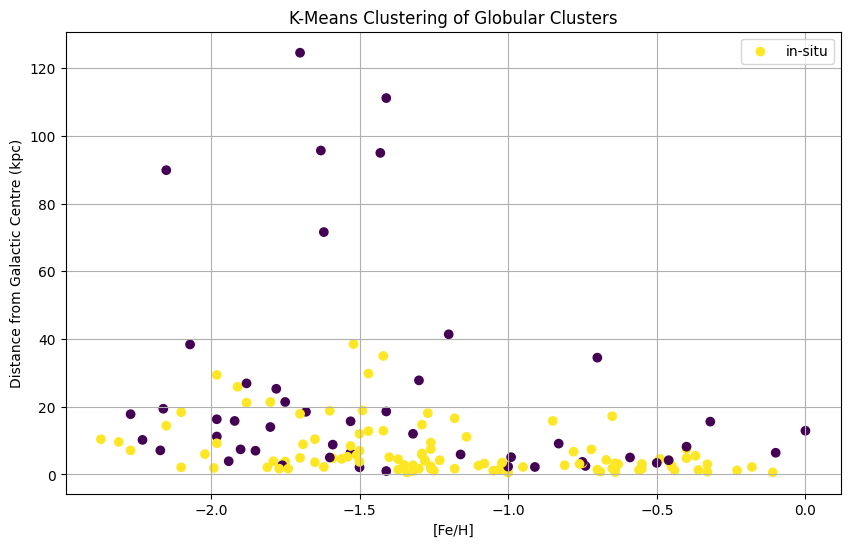

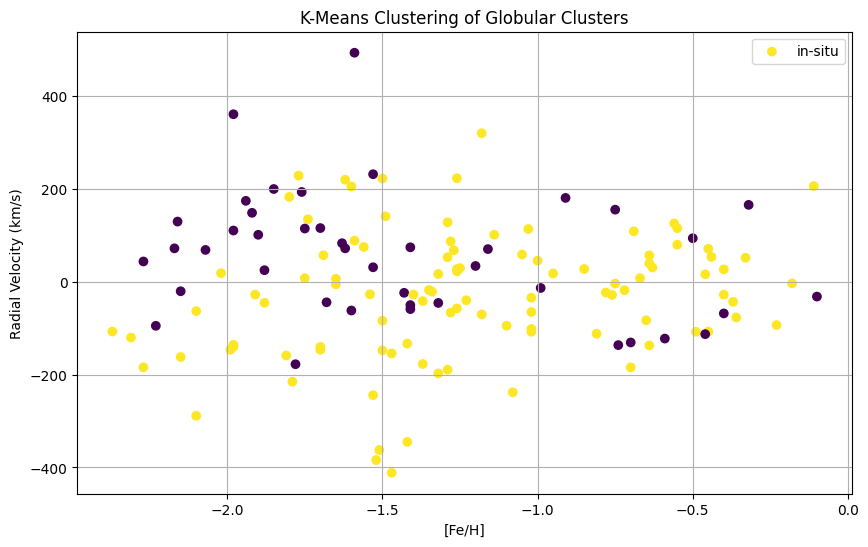

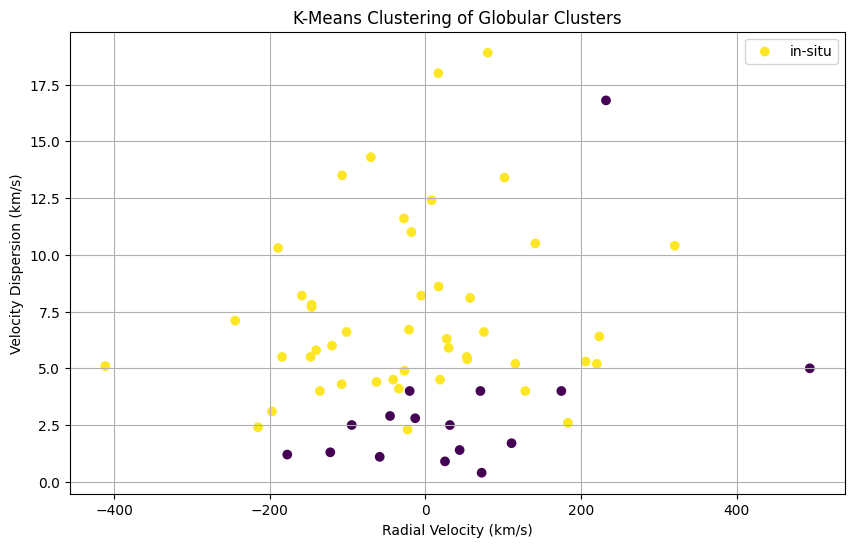

Number of in-situ GCs: 107
Number of ex-situ GCs: 50


In [139]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def kmeans_classify(k=2, title='harris_clusters.csv', variables=None):
    """
    Note: The output classification 0 or 1 must be interpreted manually as either 1=in-situ or 1=ex-situ,
    since the algorithm is unsupervised.
    
    Args:
        k (int, optional): _description_. Defaults to 2.
        title (str, optional): _description_. Defaults to 'harris_clusters.csv'.
        variables (_type_, optional): _description_. Defaults to None.

    Returns:
        Dataframe: entire Harris Dataframe, with 'classification' column (0 or 1)
    """
    # Merge all parts on 'ID' (Cluster identification)
    merged_data = harris_p1.merge(harris_p2, on="ID").merge(harris_p3, on="ID")

    # Select only numerical columns for clustering
    numerical_data = merged_data.select_dtypes(include=['float64', 'int64'])
    
    if variables:
        numerical_data = numerical_data[variables]

    # Handle missing values (NaNs) by filling them with the mean of the respective column
    numerical_data.fillna(numerical_data.mean(), inplace=True)

    print(numerical_data.columns)

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numerical_data)

    # Apply K-means clustering (Assume we want 2 clusters: accreted and native)
    kmeans = KMeans(n_clusters=2, random_state=42)

    merged_data['classification'] = kmeans.fit_predict(scaled_data)

    # Save the results to a new CSV file
    merged_data.to_csv('data/Option 1/out/harris_clusters.csv', index=False)
    # print(merged_data[['ID', 'classification']].head())
    
    return merged_data


def plot_classifications(merged_data, x, y, xtitle='', ytitle='', showCounts=False):
    # Plot the clusters (using two features for visualization)
    plt.figure(figsize=(10, 6))
    plt.scatter(merged_data[x], merged_data[y], c=merged_data['classification'], cmap='viridis')
    plt.title('K-Means Clustering of Globular Clusters')
    plt.xlabel(xtitle if xtitle else x)
    plt.ylabel(ytitle if ytitle else y)
    plt.grid(True)
    plt.legend(["in-situ", "ex-situ"])
    plt.show()
    
    if showCounts:
        nin = len(merged_data[merged_data['classification'] == 1])
        nex = len(merged_data[merged_data['classification'] == 0])
        print(f'Number of in-situ GCs: {nin}\nNumber of ex-situ GCs: {nex}')
    

merged_data = kmeans_classify()

plot_classifications(merged_data, '[Fe/H]', 'R_gc', ytitle='Distance from Galactic Centre (kpc)')
plot_classifications(merged_data, '[Fe/H]', 'v_r', ytitle='Radial Velocity (km/s)')
plot_classifications(merged_data, 'v_r', 'sig_v', xtitle='Radial Velocity (km/s)', ytitle='Velocity Dispersion (km/s)', showCounts=True)


Index(['R_gc', 'v_r', 'sig_v', '[Fe/H]'], dtype='object')


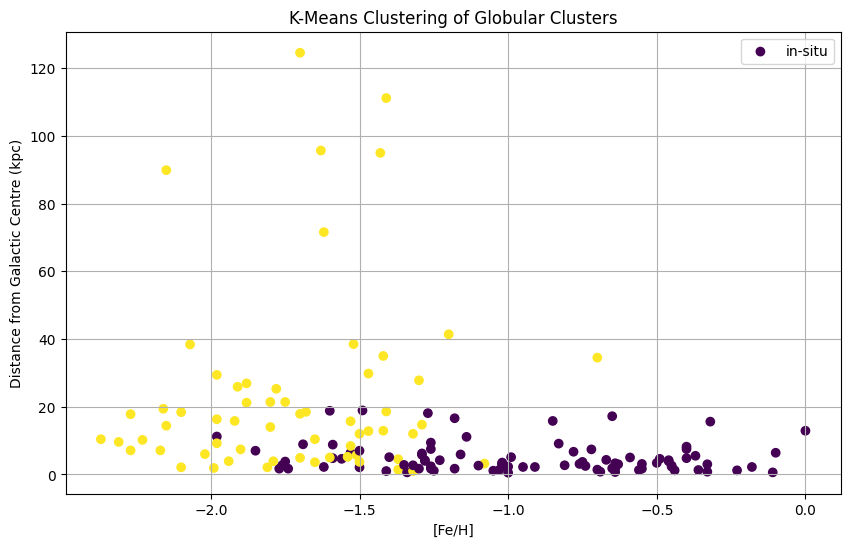

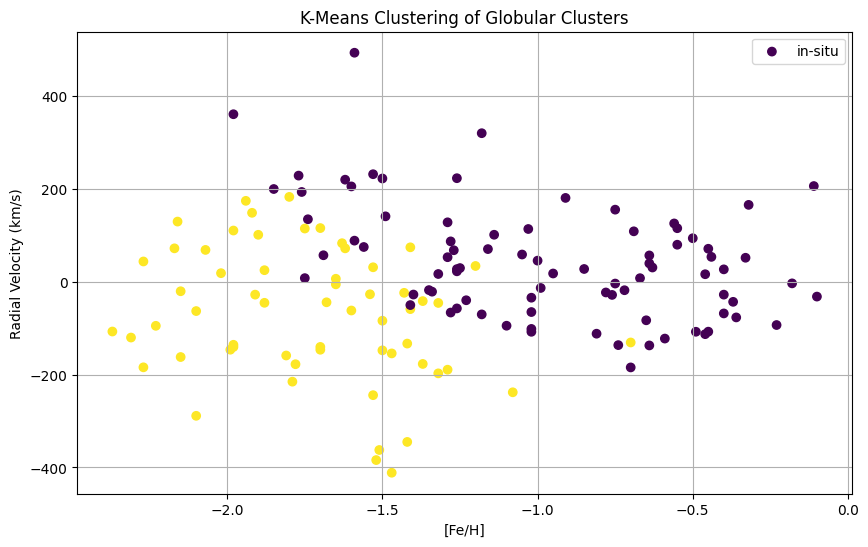

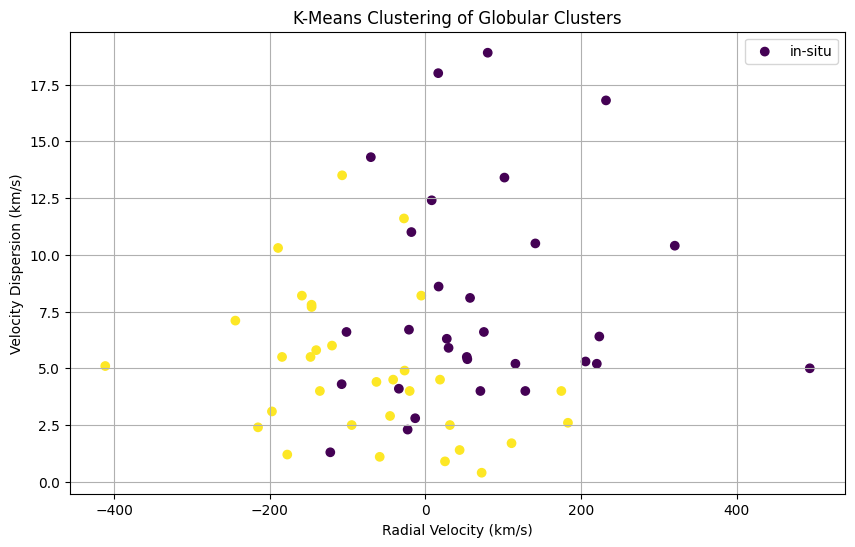

Number of in-situ GCs: 63
Number of ex-situ GCs: 94


In [126]:
# reduced dimensionality
variables = ['R_gc', 'v_r', 'sig_v', '[Fe/H]']
reduced = kmeans_classify(2, 'reduced', variables)

plot_classifications(reduced, '[Fe/H]', 'R_gc', ytitle='Distance from Galactic Centre (kpc)')
plot_classifications(reduced, '[Fe/H]', 'v_r', ytitle='Radial Velocity (km/s)')
plot_classifications(reduced, 'v_r', 'sig_v', xtitle='Radial Velocity (km/s)', ytitle='Velocity Dispersion (km/s)', showCounts=True)


In [127]:
# https://websites.umich.edu/~ognedin/mw_gc_classification.txt
chen = pd.read_csv('data/Option 1/chen_classification.csv')
print(chen['ID'][0:5], chen['Class'][0:5])

ids, clss = [], []
for r in chen['ID']:
    id, cls = r.split()
    id = id.replace('_', ' ')
    ids.append(id)
    clss.append(1 if cls == 'in-situ' else 0)

print(ids)

chen2 = pd.DataFrame()
chen2['ID'] = ids
chen2['chen_class'] = clss
chen2.to_csv('data/Option 1/out/chen_classification.csv', index=False)

# reduced = reduced.merge(chen2, on='ID')
# reduced.to_csv('data/Option 1/out/test.csv', index=False)

    

0    1636-283    in-situ   
1    BH_261      in-situ   
2    Djor_2      in-situ   
3    HP_1        in-situ   
4    IC_1276     in-situ   
Name: ID, dtype: object 0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: Class, dtype: float64
['1636-283', 'BH 261', 'Djor 2', 'HP 1', 'IC 1276', 'Lynga 7', 'NGC 104', 'NGC 4372', 'NGC 5927', 'NGC 6171', 'NGC 6218', 'NGC 6266', 'NGC 6293', 'NGC 6304', 'NGC 6316', 'NGC 6325', 'NGC 6342', 'NGC 6352', 'NGC 6355', 'NGC 6356', 'NGC 6362', 'NGC 6366', 'NGC 6380', 'NGC 6388', 'NGC 6397', 'NGC 6440', 'NGC 6496', 'NGC 6522', 'NGC 6528', 'NGC 6539', 'NGC 6540', 'NGC 6553', 'NGC 6558', 'NGC 6569', 'NGC 6624', 'NGC 6626', 'NGC 6637', 'NGC 6638', 'NGC 6642', 'NGC 6652', 'NGC 6656', 'NGC 6717', 'NGC 6723', 'NGC 6749', 'NGC 6752', 'NGC 6760', 'NGC 6838', 'Pal 1', 'Pal 8', 'Pal 10', 'Pal 11', 'Ter 1', 'Ter 2', 'Ter 3', 'Ter 4', 'Ter 5', 'Ter 6', 'Ter 9', 'Ter 12', 'NGC 5946', 'NGC 5986', 'NGC 6093', 'NGC 6121', 'NGC 6139', 'NGC 6144', 'NGC 6254', 'NGC 6256', 'NGC 62

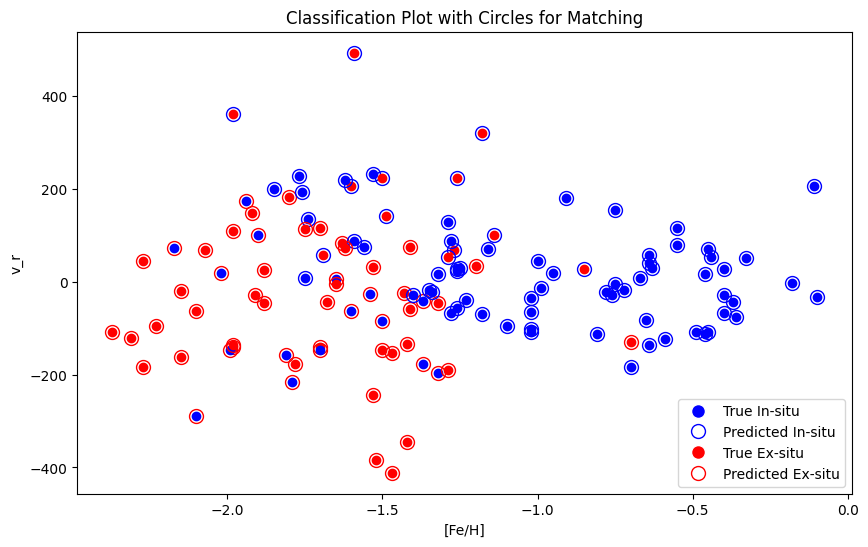

82 54
58 78
0.7941176470588235


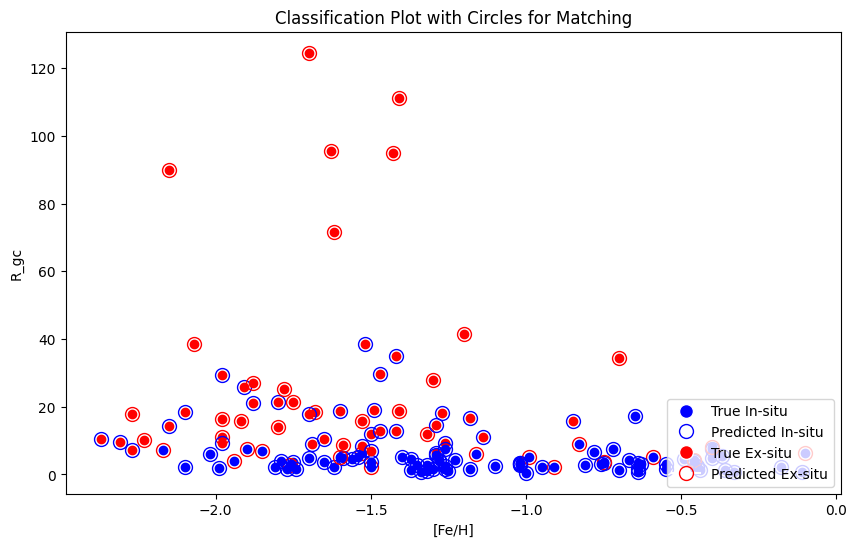

82 54
95 41
0.6544117647058824


In [138]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Function to calculate accuracy between classification and chen_class
def calculate_accuracy(df, insitu_cls_num=1):
    
    df = df.merge(chen2, on='ID')
    # Check where classification equals chen_class
    if insitu_cls_num == 1:
        correct = df['classification'] == df['chen_class']
    else:
        correct = df['classification'] != df['chen_class']
    accuracy = correct.mean()
    
    print(len(df[df['chen_class'] == 1]), len(df[df['chen_class'] == 0]))
    print(len(df[df['classification'] == 1]), len(df[df['classification'] == 0]))
    
    return accuracy

# Function to plot points based on chen_class_x and chen_class_y, with circles for classification matches
def plot_classification(df, x_col, y_col, insitu_cls_num=1):
    plt.figure(figsize=(10, 6))
    
    df = df.merge(chen2, on='ID')
    # print(df.head())
    
    for i, row in df.iterrows():
        x = row[x_col]
        y = row[y_col]
        classification = row['classification']
        chen_class = row['chen_class']
        
        # Color the points based on classification
        color = 'blue' if chen_class == 1 else 'red'
        circle_color = 'blue' if classification == insitu_cls_num else 'red'
        
        # Plot the points
        plt.plot(x, y, marker='o', color=color, label="in-situ" if classification else "ex-situ")
        plt.plot(x, y, marker='o', markersize=10, mfc='none', color=circle_color, label="in-situ" if chen_class else "ex-situ")

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title('Classification Plot with Circles for Matching')
    
    
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='True In-situ', markerfacecolor='blue', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Predicted In-situ', markeredgecolor='blue', markerfacecolor='none', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='True Ex-situ', markerfacecolor='red', markersize=10),
        Line2D([0], [0], marker='o', color='w', label='Predicted Ex-situ', markeredgecolor='red', markerfacecolor='none', markersize=10)
    ]
    
    plt.legend(handles=legend_elements, loc='lower right')
    plt.show()


# Plot the classification points
# isitu_cls_num determined empirically
plot_classification(reduced, '[Fe/H]', 'v_r', insitu_cls_num=0)
print(calculate_accuracy(reduced, insitu_cls_num=0))

plot_classification(merged_data, '[Fe/H]', 'R_gc')
print(calculate_accuracy(merged_data))

